In [2]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')


import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
from imblearn.over_sampling import SMOTE, ADASYN


from technicalSignals import Indicators


In [3]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
kind_of_dataset = 'Summary'


In [4]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret_test = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)


        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 21, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                      'SMA_30','SMA_50','SMA_100','SMA_150',
                      'in_BBands', 'eccessVolumes']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        self.cum_ret_test = []
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(0 if cumulative_return<0 else 1)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
            self.cum_ret_test.append(cumulative_return)
        
       #y = self.normalize(np.array(y))
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        self.cum_ret_test = self.cum_ret_test[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    




In [5]:
def cv(x_tv,y_tv):
    best_mcc = -float(np.inf)
    best_c = 0
    best_g = 0
    for c in np.logspace(-2,5,30):
        for g in np.logspace(-5,2,30):
            print('.', end='')
            trainpoint=math.floor(len(x_tv)*0.50)
            dimval=math.floor(trainpoint*0.25)
            endval=trainpoint+dimval
            #Cross validation
            cvMCC = 0
            for i in range(0,4):
                x_train=x_tv[0:trainpoint]
                y_train=y_tv[0:trainpoint]
                x_val=x_tv[trainpoint:endval]
                y_val=y_tv[trainpoint:endval]
                trainpoint=trainpoint+dimval
                endval=endval+dimval
                if ((sum(y_val)+6<len(x_val) and sum(y_val)>6)):
                    x_train,y_train=smote(x_train,y_train)
                    x_val,y_val=smote(x_val,y_val)
                svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                svm_model.fit(x_train,y_train)
                y_pred = svm_model.predict(x_val)
                confmatrix = confusion_matrix(y_val, y_pred)
                tn, fp, fn, tp = confmatrix.ravel()
                denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
                cvMCC += mcc/4

            if(cvMCC > best_mcc):
                best_mcc = cvMCC
                best_c = c
                best_g = g
    return (best_c,best_g)

def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

In [6]:
model_selection_values = {('AAPL', -48, 0): (41.753189365604044, 0.013738237958832637),
                          ('AAPL', -35, 0): (126.89610031679234, 0.007880462815669913),
                          ('AAPL', -28, 0): (18873.918221350996, 0.00016102620275609394),
                          ('AAPL', -7, 0): (126.89610031679234, 0.07278953843983153),
                          ('AAPL', -1, 0): (3562.2478902624443, 0.0002807216203941176), 
                          ('AAPL', 1, 2): (6210.169418915616, 9.236708571873866e-05), 
                          ('AAPL', 1, 8): (1.4873521072935119, 1.1721022975334818), 
                          ('AAPL', 1, 29): (0.853167852417281, 2.043359717856944), 
                          ('AAPL', 1, 36): (0.2807216203941177, 1.1721022975334818),
                          ('AAPL', 1, 50): (126.89610031679234, 5.2983169062837125e-05),
                          ('AMZN', -48, 0): (72.78953843983153, 0.004520353656360245),
                          ('AMZN', -35, 0): (1172.1022975334818, 0.002592943797404667),
                          ('AMZN', -28, 0): (72.78953843983153, 0.07278953843983153),
                          ('AMZN', -7, 0): (10826.36733874054, 0.0002807216203941176), 
                          ('AMZN', -1, 0): (72.78953843983153, 0.013738237958832637), 
                          ('AMZN', 1, 2): (100000.0, 0.00016102620275609394), 
                          ('AMZN', 1, 8): (32903.44562312671, 0.0004893900918477494),
                          ('AMZN', 1, 29): (3562.2478902624443, 0.6723357536499335),
                          ('AMZN', 1, 36): (0.03039195382313198, 0.22122162910704501),
                          ('AMZN', 1, 50): (0.09236708571873865, 0.04175318936560404),
                          ('GOOGL', -48, 0): (0.853167852417281, 0.38566204211634725), 
                          ('GOOGL', -35, 0): (1172.1022975334818, 0.00016102620275609394), 
                          ('GOOGL', -28, 0): (18873.918221350996, 5.2983169062837125e-05),
                          ('GOOGL', -7, 0): (41.753189365604044, 0.07278953843983153),
                          ('GOOGL', -1, 0): (100000.0, 1.7433288221999873e-05),
                          ('GOOGL', 1, 2): (672.3357536499335, 0.004520353656360245),
                          ('GOOGL', 1, 8): (57361.52510448681, 0.02395026619987486), 
                          ('GOOGL', 1, 29): (0.017433288221999882, 2.043359717856944), 
                          ('GOOGL', 1, 36): (23.95026619987486, 0.6723357536499335), 
                          ('GOOGL', 1, 50): (0.853167852417281, 0.6723357536499335),
                          ('MSFT', -48, 0): (6210.169418915616, 0.002592943797404667),
                          ('MSFT', -35, 0): (100000.0, 0.0004893900918477494), 
                          ('MSFT', -28, 0): (57361.52510448681, 0.0002807216203941176), 
                          ('MSFT', -7, 0): (32903.44562312671, 0.0008531678524172815), 
                          ('MSFT', -1, 0): (57361.52510448681, 0.004520353656360245),
                          ('MSFT', 1, 2): (0.09236708571873865, 0.12689610031679235), 
                          ('MSFT', 1, 8): (23.95026619987486, 0.0004893900918477494), 
                          ('MSFT', 1, 29): (385.6620421163472, 9.236708571873866e-05), 
                          ('MSFT', 1, 36): (0.09236708571873865, 0.12689610031679235), 
                          ('MSFT', 1, 50): (0.017433288221999882, 0.38566204211634725),
                          ('FB', -48, 0): (100000.0, 0.0004893900918477494), 
                          ('FB', -35, 0): (1172.1022975334818, 0.002592943797404667), 
                          ('FB', -28, 0): (10826.36733874054, 0.004520353656360245), 
                          ('FB', -7, 0): (32903.44562312671, 1e-05),
                          ('FB', -1, 0): (672.3357536499335, 0.007880462815669913), 
                          ('FB', 1, 2): (0.01, 0.004520353656360245), 
                          ('FB', 1, 8): (2.592943797404667, 1.1721022975334818), 
                          ('FB', 1, 29): (0.4893900918477494, 0.02395026619987486),
                          ('FB', 1, 36): (2.592943797404667, 1e-05),
                          ('FB', 1, 50): (0.017433288221999882, 0.0004893900918477494),
                          ('INTC', -48, 0): (32903.44562312671, 0.00016102620275609394),
                          ('INTC', -35, 0): (2043.3597178569437, 0.0014873521072935117),
                          ('INTC', -28, 0): (10826.36733874054, 0.0004893900918477494), 
                          ('INTC', -7, 0): (6210.169418915616, 0.002592943797404667),
                          ('INTC', -1, 0): (57361.52510448681, 0.0014873521072935117), 
                          ('INTC', 1, 2): (672.3357536499335, 1e-05),
                          ('INTC', 1, 8): (385.6620421163472, 1.1721022975334818), 
                          ('INTC', 1, 29): (18873.918221350996, 0.0004893900918477494), 
                          ('INTC', 1, 36): (10826.36733874054, 0.0002807216203941176),
                          ('INTC', 1, 50): (100000.0, 1e-05), 
                          ('CSCO', -48, 0): (3562.2478902624443, 0.0014873521072935117),
                          ('CSCO', -35, 0): (2.592943797404667, 5.2983169062837125e-05), 
                          ('CSCO', -28, 0): (57361.52510448681, 0.0004893900918477494),
                          ('CSCO', -7, 0): (18873.918221350996, 0.0014873521072935117), 
                          ('CSCO', -1, 0): (41.753189365604044, 0.0014873521072935117),
                          ('CSCO', 1, 2): (221.22162910704503, 0.0008531678524172815),
                          ('CSCO', 1, 8): (2043.3597178569437, 5.2983169062837125e-05),
                          ('CSCO', 1, 29): (18873.918221350996, 0.0014873521072935117), 
                          ('CSCO', 1, 36): (100000.0, 0.0002807216203941176), 
                          ('CSCO', 1, 50): (100000.0, 0.00016102620275609394), 
                          ('CMCSA', -48, 0): (32903.44562312671, 0.0014873521072935117),
                          ('CMCSA', -35, 0): (1172.1022975334818, 0.00016102620275609394), 
                          ('CMCSA', -28, 0): (2043.3597178569437, 0.013738237958832637), 
                          ('CMCSA', -7, 0): (57361.52510448681, 5.2983169062837125e-05), 
                          ('CMCSA', -1, 0): (72.78953843983153, 0.22122162910704501), 
                          ('CMCSA', 1, 2): (2.592943797404667, 1.1721022975334818),
                          ('CMCSA', 1, 8): (0.03039195382313198, 0.07278953843983153),
                          ('CMCSA', 1, 29): (0.16102620275609392, 0.12689610031679235), 
                          ('CMCSA', 1, 36): (3562.2478902624443, 1.1721022975334818),
                          ('CMCSA', 1, 50): (0.03039195382313198, 0.22122162910704501),
                          ('NVDA', -48, 0): (385.6620421163472, 0.002592943797404667), 
                          ('NVDA', -35, 0): (23.95026619987486, 0.0008531678524172815), 
                          ('NVDA', -28, 0): (3562.2478902624443, 0.0008531678524172815), 
                          ('NVDA', -7, 0): (57361.52510448681, 9.236708571873866e-05),
                          ('NVDA', -1, 0): (2043.3597178569437, 3.039195382313195e-05), 
                          ('NVDA', 1, 2): (0.853167852417281, 0.0002807216203941176),
                          ('NVDA', 1, 8): (0.05298316906283707, 0.007880462815669913), 
                          ('NVDA', 1, 29): (4.520353656360245, 0.007880462815669913), 
                          ('NVDA', 1, 36): (0.4893900918477494, 0.013738237958832637),
                          ('NVDA', 1, 50): (57361.52510448681, 0.0008531678524172815),
                          ('NFLX', -48, 0): (2043.3597178569437, 5.2983169062837125e-05), 
                          ('NFLX', -35, 0): (41.753189365604044, 0.0004893900918477494),
                          ('NFLX', -28, 0): (32903.44562312671, 0.0002807216203941176),
                          ('NFLX', -7, 0): (10826.36733874054, 0.0014873521072935117),
                          ('NFLX', -1, 0): (385.6620421163472, 0.002592943797404667), 
                          ('NFLX', 1, 2): (57361.52510448681, 2.043359717856944), 
                          ('NFLX', 1, 8): (0.4893900918477494, 9.236708571873866e-05),
                          ('NFLX', 1, 29): (32903.44562312671, 0.04175318936560404), 
                          ('NFLX', 1, 36): (1172.1022975334818, 0.38566204211634725), 
                          ('NFLX', 1, 50): (13.738237958832638, 0.0002807216203941176)}


In [ ]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)


        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 21, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                      'SMA_30','SMA_50','SMA_100','SMA_150',
                      'in_BBands', 'eccessVolumes']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        self.cum_ret = []
        
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(0 if cumulative_return<0 else 1)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
            self.cum_ret.append(cumulative_return)
        
       #y = self.normalize(np.array(y))
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        self.cum_ret = self.cum_ret[nt:]
        
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    

ACCs_avg = np.zeros([len(TREND_WINDOWs), 5])
MCCs_avg = np.zeros([len(TREND_WINDOWs), 5])
conf_matr_avg = np.zeros([2,2])


for ticker in tickers:
    print('\n\n\n==================== '+str(ticker)+' ==================== \n\n\n')
    MCCs = []
    ACCs = []
    ds = DatasetManager()
    ds.load_dataset(ticker = ticker, kind = kind_of_dataset,technicalFeatures=True)

    for (init, finish) in TREND_WINDOWs:
        print('trend: ',init,' ',finish)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish)
        
        
        if(ticker, init, finish) in model_selection_values:
            (best_c,best_g) = model_selection_values[(ticker, init, finish)]
        else:
            (best_c,best_g) = cv(x_tv,y_tv)
            model_selection_values[(ticker, init, finish)] = (best_c,best_g)

        print('Best C: ',best_c,' best gamma: ',best_g)
        svm_model = svm.SVC(kernel='rbf', C=best_c, gamma=best_g)
        (x_tv,y_tv) = smote(x_tv,y_tv)
        svm_model.fit(x_tv,y_tv)
        acc = svm_model.score(x_test,y_test)
        y_pred = svm_model.decision_function(x_test)
        np.savetxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', y_pred, delimiter=",")
        thresholds = np.linspace(0, max(np.absolute(y_pred)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            weights_over_th = []
            for y, y_p in zip(y_test, y_pred):
                if(abs(y_p)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
            mcc = matthews_corrcoef(y_over_th, sign(y_pred_over_th))
            acc = accuracy_score(y_over_th, sign(y_pred_over_th))
            print(acc, mcc)
            ACCs_avg[TREND_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[TREND_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

plt.figure(figsize=(20,10))
plt.plot(MCCs_avg,'--r', label='MCC')
plt.plot(ACCs_avg,'r', label='ACC')
plt.xlabel('timewindows')
plt.xticks(range(0,len(TREND_WINDOWs)), TREND_WINDOWs)
plt.title('AVERAGE VALUES, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
print(model_selection_values)

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


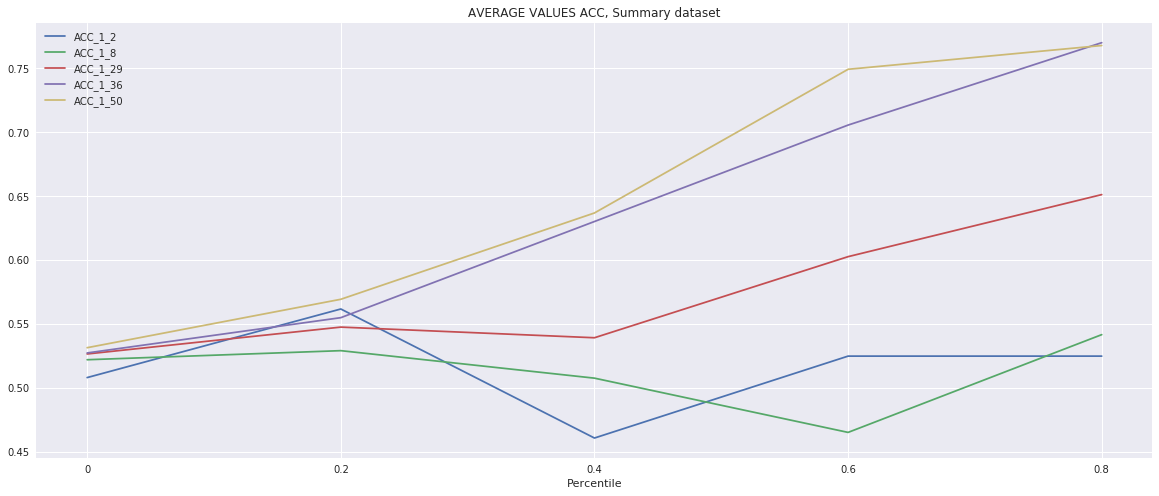

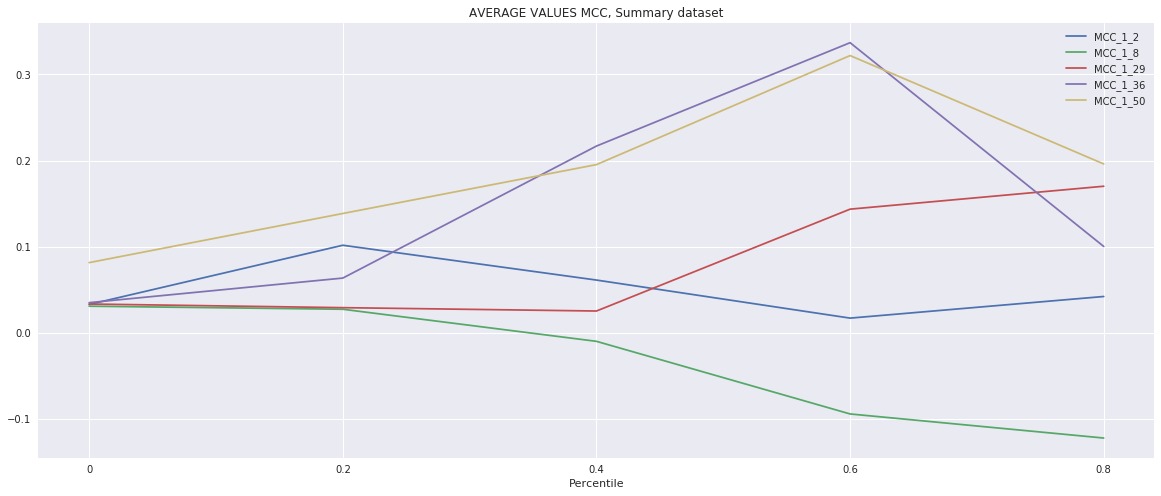

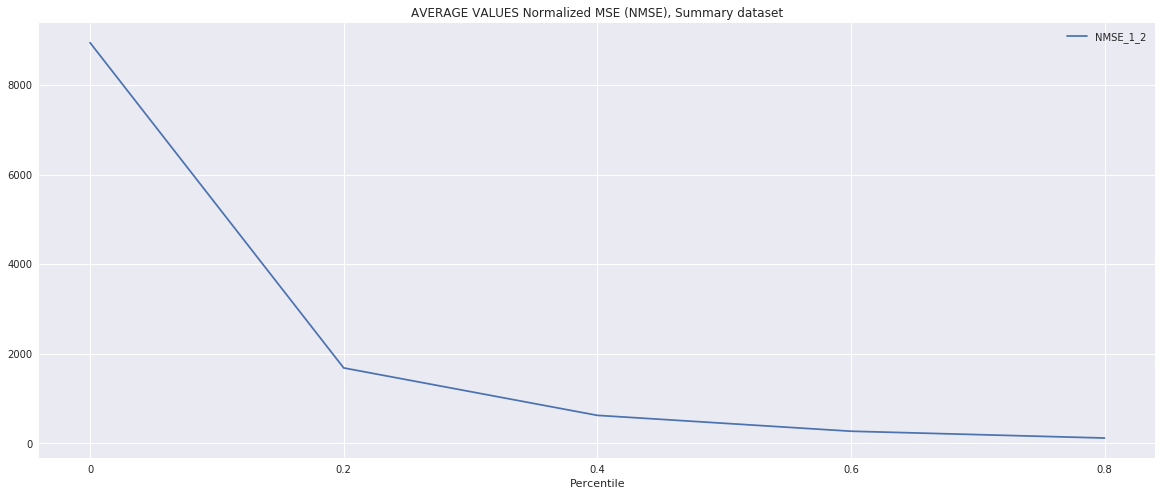

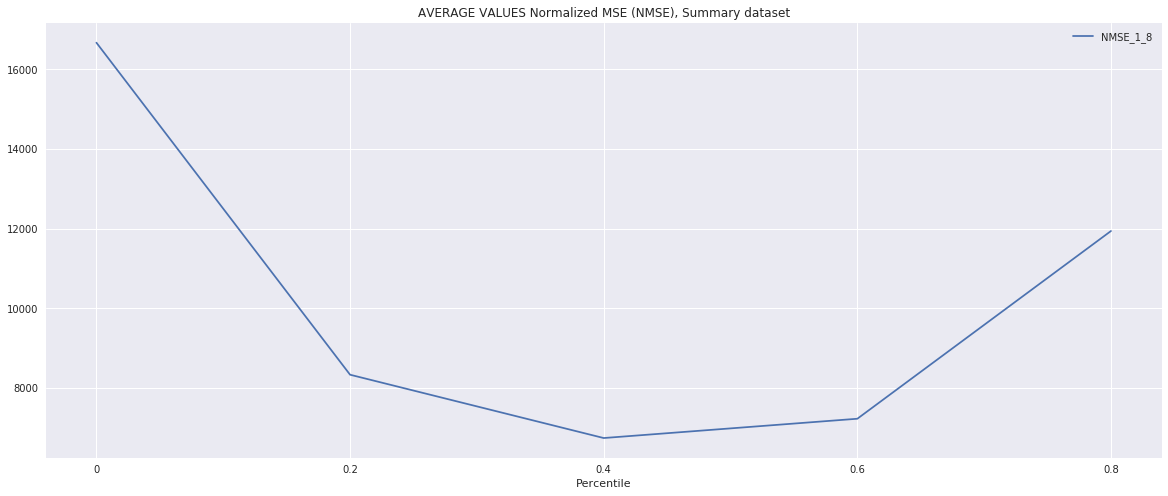

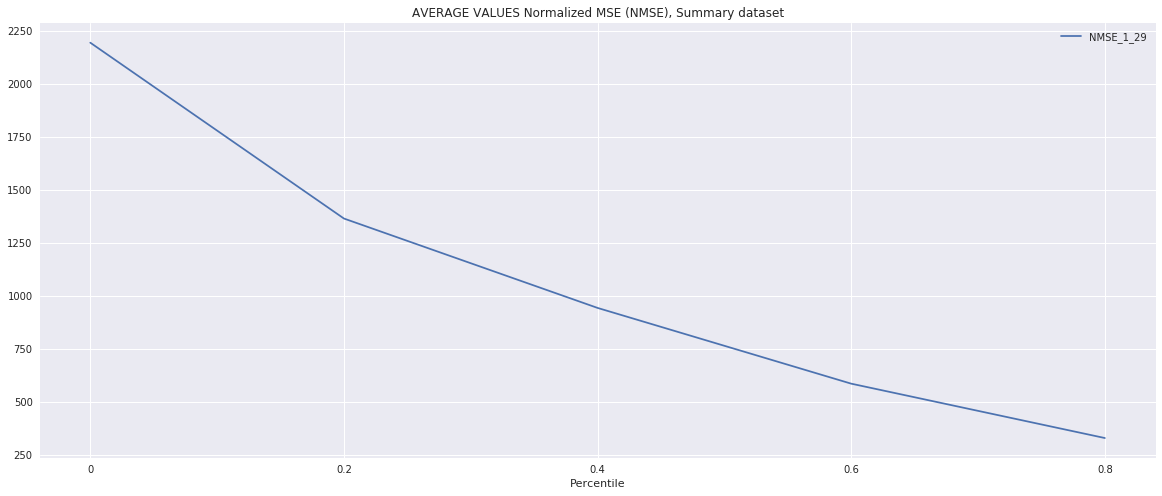

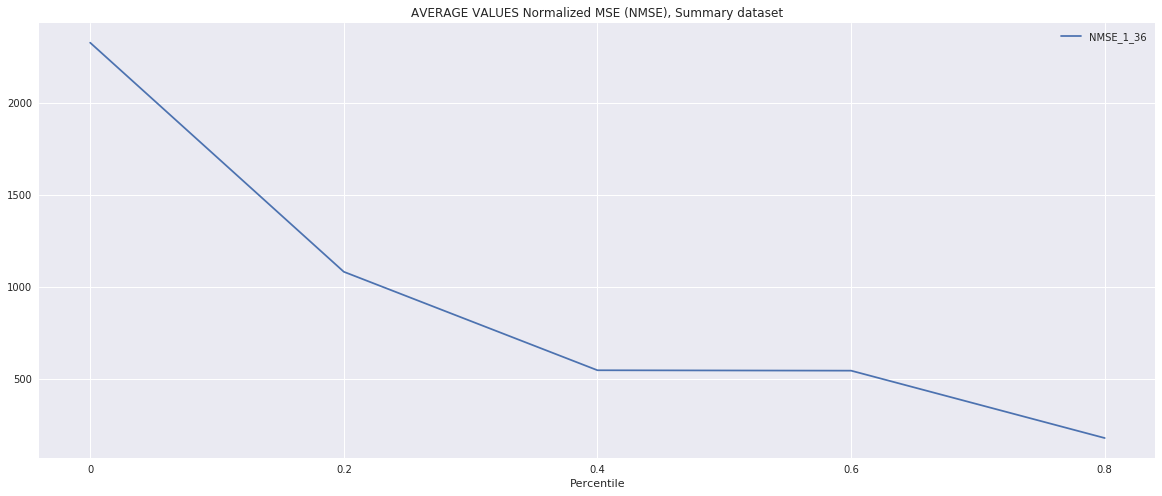

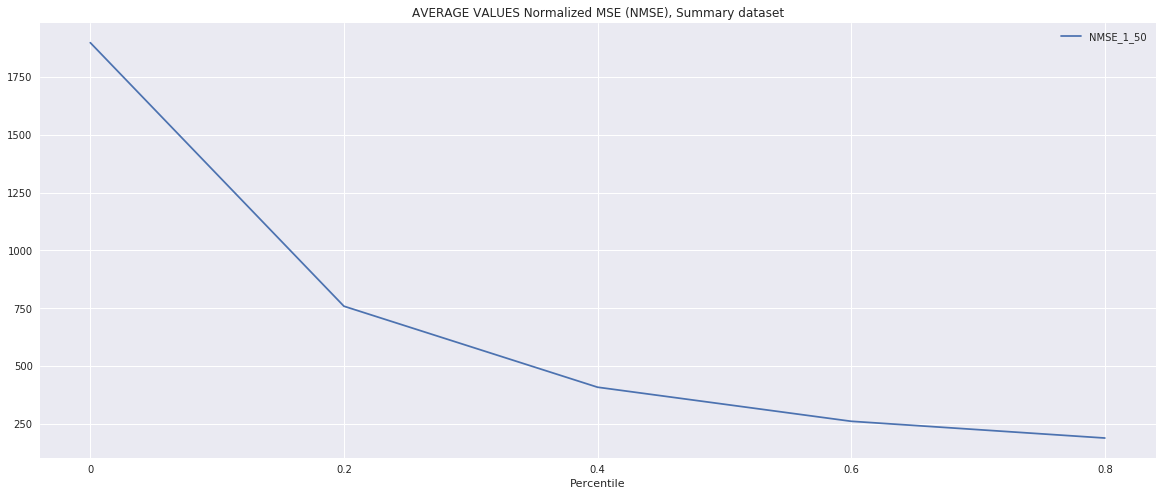

In [9]:
#Predictions Percentile on fluctuations
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        y_test = ds.cum_ret_test
        thresholds = np.linspace(0, max(np.absolute(y_test)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            for y, y_p in zip(y_test, y_pred):
                if(abs(y)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

    labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(20,8)) 
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 

np.savetxt('NMSE_percentile_on_fluctuations.csv', NMSEs_avg, delimiter=",")
np.savetxt('ACC_percentile_on_fluctuations.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_fluctuations.csv', MCCs_avg, delimiter=",")

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36


/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


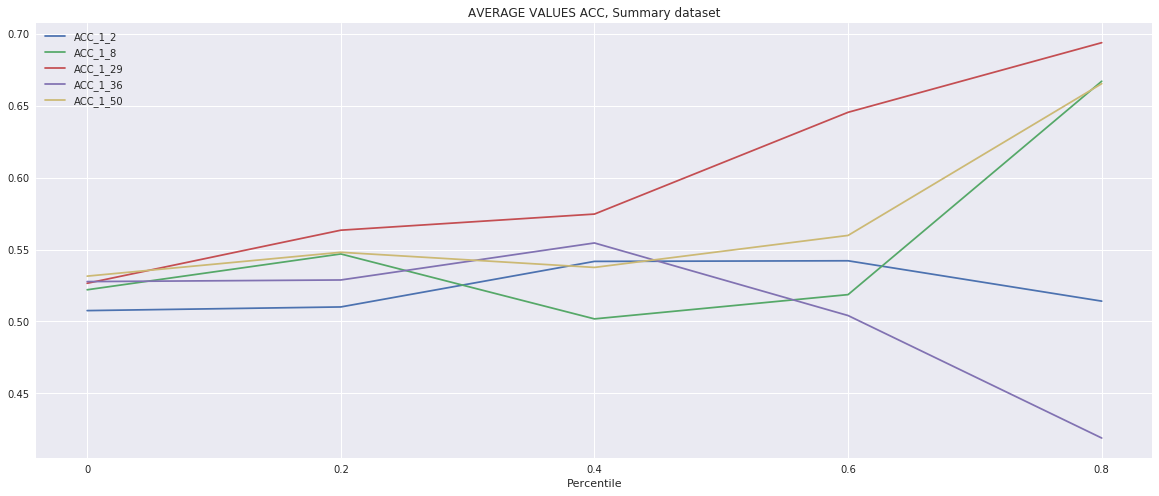

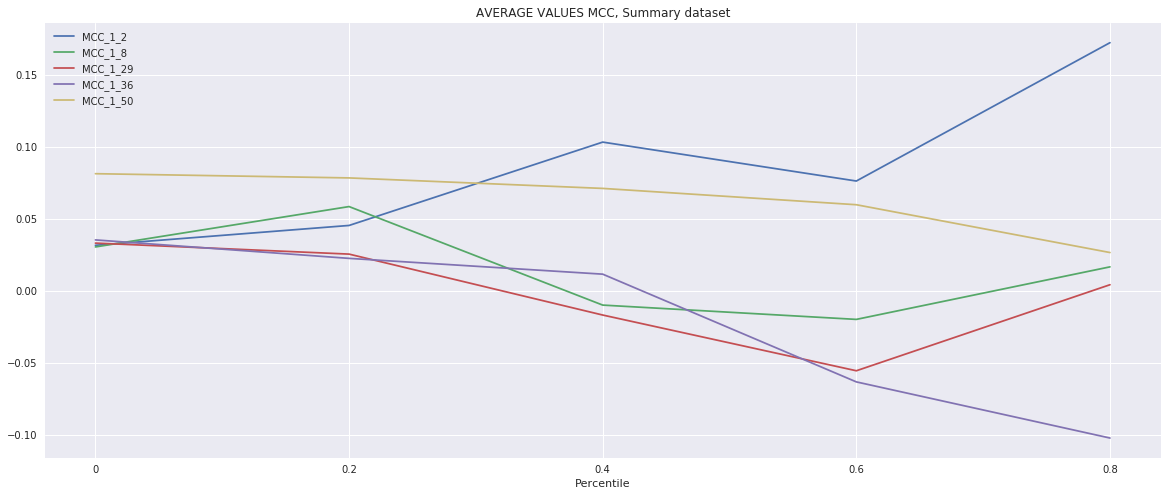

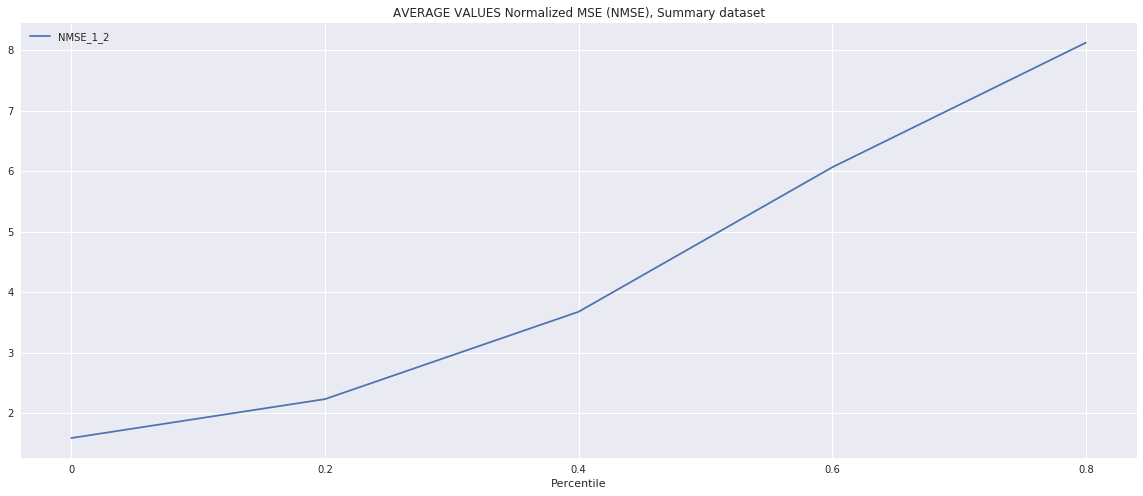

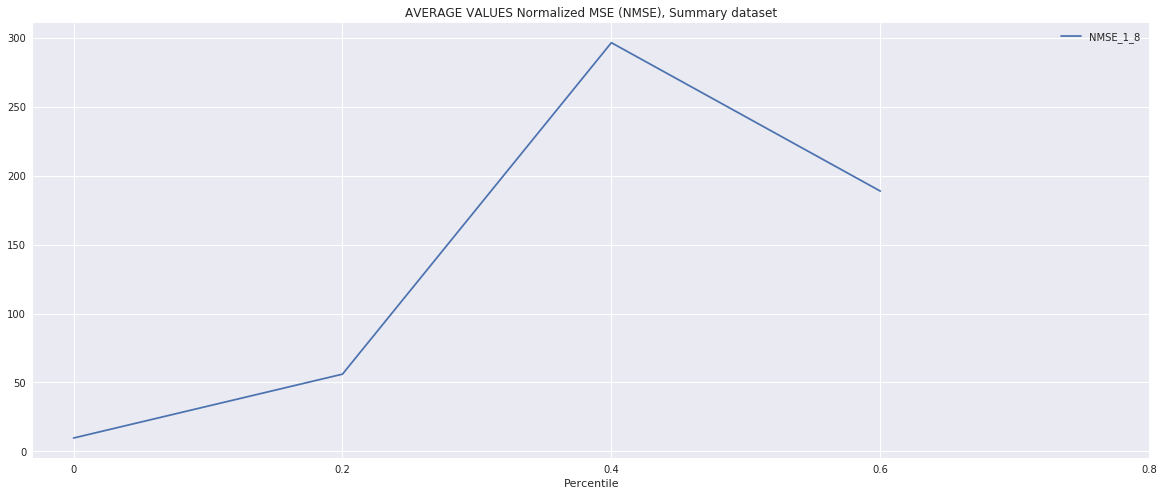

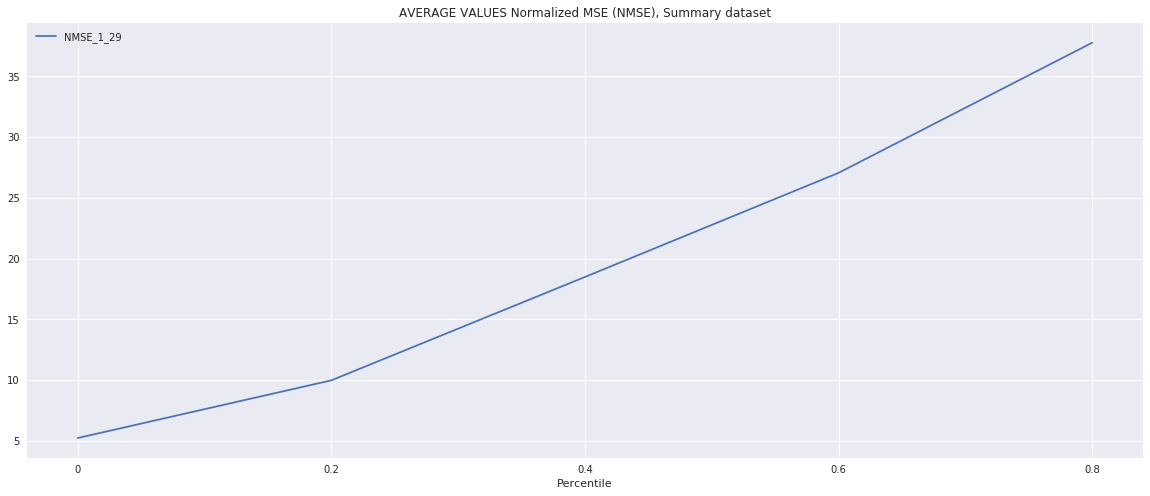

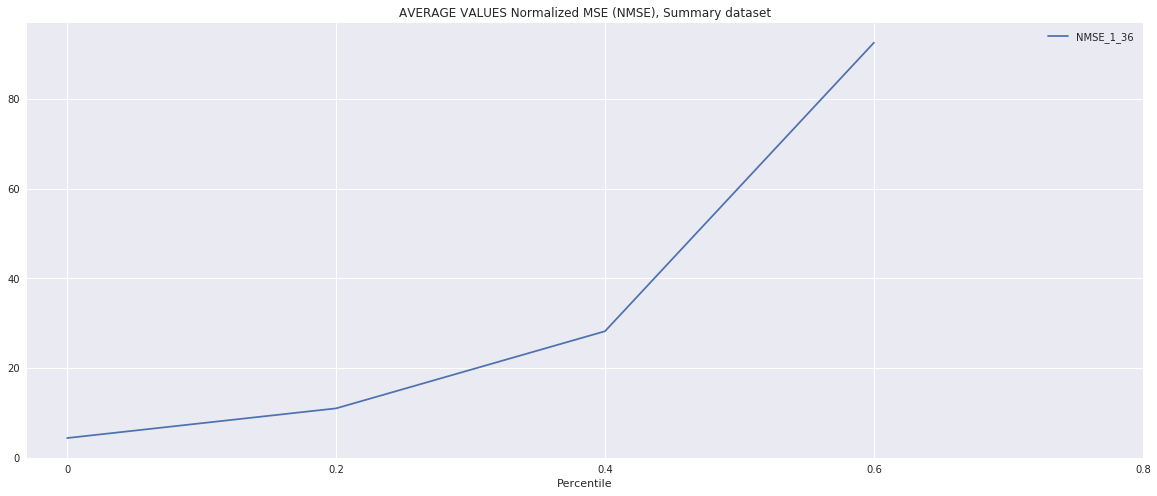

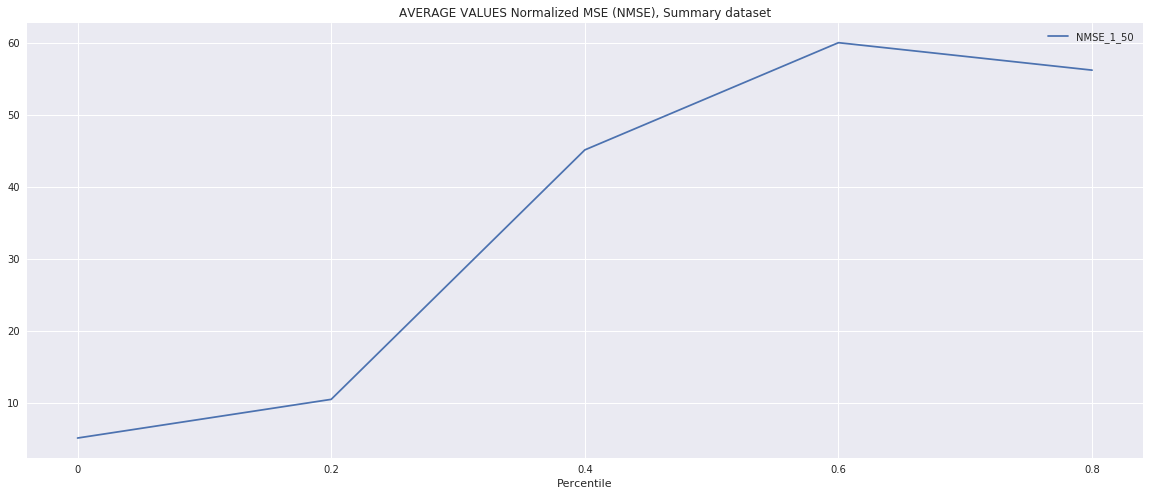

In [10]:
#Predictions percentile on predictions
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 5])
MSEs_avg_weight = np.zeros([len(FUTURE_WINDOWs), 5])

for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        
        thresholds = np.linspace(0, max(np.absolute(y_pred)), num=6)[:-1]
        for t in range(0,5):
            threshold = thresholds[t]
            y_over_th = []
            y_pred_over_th = []
            for y, y_p in zip(y_test, y_pred):
                if(abs(y_p)> threshold):
                    y_over_th.append(y)
                    y_pred_over_th.append(y_p)
            nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
            mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
            acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
            NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= nmse/len(tickers)
            ACCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= acc/len(tickers)
            MCCs_avg[FUTURE_WINDOWs.index((init, finish)), t]+= mcc/len(tickers)

labels = [0,0.2,.4,.6,.8]
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(ACCs_avg[i,:], label='ACC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES ACC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
plt.figure(figsize=(20,8))
for i in range(len(FUTURE_WINDOWs)):
    plt.plot(MCCs_avg[i,:], label='MCC_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
plt.xlabel('Percentile')
plt.xticks(range(0,len(labels)), labels)
plt.title('AVERAGE VALUES MCC, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(20,8))
    plt.plot(NMSEs_avg[i,:], label='NMSE_'+str(FUTURE_WINDOWs[i][0])+'_'+str(FUTURE_WINDOWs[i][1]))
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('AVERAGE VALUES Normalized MSE (NMSE), '+str(kind_of_dataset)+' dataset')
    plt.legend()
    plt.show() 
    

np.savetxt('NMSE_percentile_on_predictions.csv', NMSEs_avg, delimiter=",")
np.savetxt('ACC_percentile_on_predictions.csv', ACCs_avg, delimiter=",")
np.savetxt('MCC_percentile_on_predictions.csv', MCCs_avg, delimiter=",")

AAPL   1   2


/home/simone/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


AAPL   1   8
AAPL   1   29
AAPL   1   36
AAPL   1   50
AMZN   1   2
AMZN   1   8
AMZN   1   29
AMZN   1   36
AMZN   1   50
GOOGL   1   2
GOOGL   1   8
GOOGL   1   29
GOOGL   1   36
GOOGL   1   50
MSFT   1   2
MSFT   1   8
MSFT   1   29
MSFT   1   36
MSFT   1   50
FB   1   2
FB   1   8
FB   1   29
FB   1   36
FB   1   50
INTC   1   2
INTC   1   8
INTC   1   29
INTC   1   36
INTC   1   50
CSCO   1   2
CSCO   1   8
CSCO   1   29
CSCO   1   36
CSCO   1   50
CMCSA   1   2
CMCSA   1   8
CMCSA   1   29
CMCSA   1   36
CMCSA   1   50
NVDA   1   2
NVDA   1   8
NVDA   1   29
NVDA   1   36
NVDA   1   50
NFLX   1   2
NFLX   1   8
NFLX   1   29
NFLX   1   36
NFLX   1   50


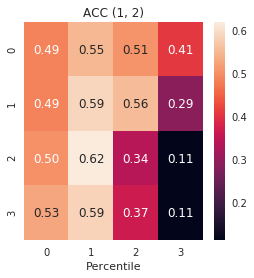

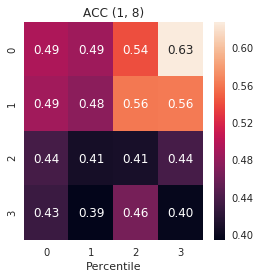

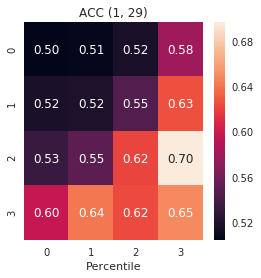

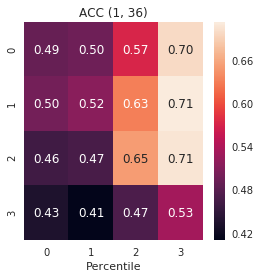

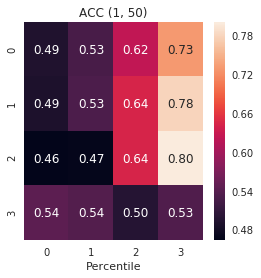

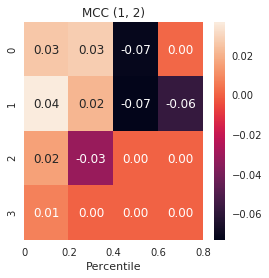

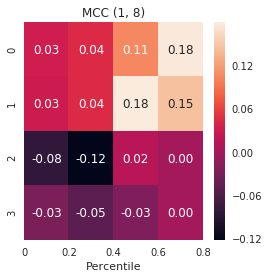

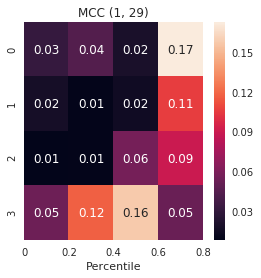

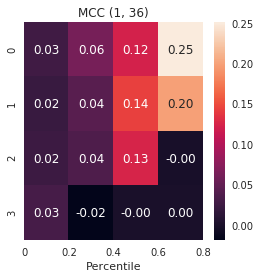

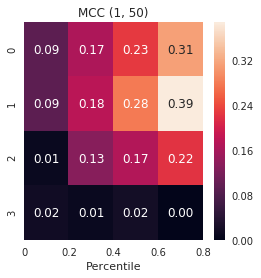

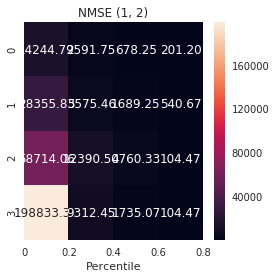

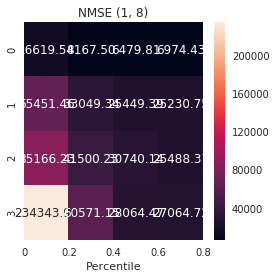

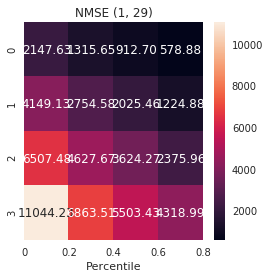

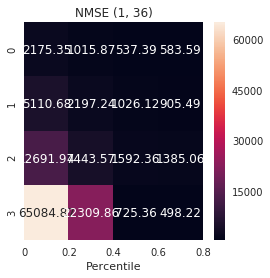

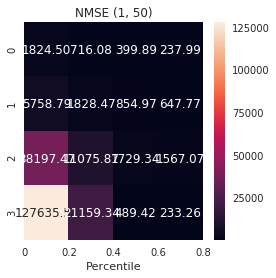

Conf matr (1, 2)
[[230.2  37.1]
 [253.6  48.1]]
Conf matr (1, 8)
[[206.5  52.6]
 [234.4  73.5]]
Conf matr (1, 29)
[[165.   77.5]
 [200.5 118. ]]
Conf matr (1, 36)
[[152.7  82.3]
 [203.  121. ]]
Conf matr (1, 50)
[[150.8  73.9]
 [207.5 122.8]]


In [7]:
#Predictions percentile on predictions and fluctuations
import seaborn as sns; sns.set()
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

def sign(vec):
    return [1 if v>0 else 0 for v in vec]

FUTURE_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
NMSEs_avg = np.zeros([len(FUTURE_WINDOWs), 4,4])
ACCs_avg = np.zeros([len(FUTURE_WINDOWs), 4,4])
MCCs_avg = np.zeros([len(FUTURE_WINDOWs), 4,4])
CM_avg = np.zeros([len(FUTURE_WINDOWs), 2,2])



for ticker in tickers:
    for (init, finish) in FUTURE_WINDOWs:
        print(ticker,' ',init,' ',finish)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        y_pred = np.loadtxt('test_predictions/'+ticker+'_'+str(init)+'_'+str(finish)+'.csv', delimiter=",")
        y_pred = [y_p - 0.5 for y_p in y_pred] 
        y_test = ds.cum_ret_test
        CM_avg[FUTURE_WINDOWs.index((init, finish)), :,:] +=confusion_matrix(sign(y_test),sign(y_pred))/len(tickers)
        threshPred = np.linspace(0, max(np.absolute(y_pred)), num=6)[:-2]
        threshFluct = np.linspace(0, max(np.absolute(y_test)), num=6)[:-2]
        for tP in range(0,4):
            for tF in range(0,4):
                threshP = threshPred[tP]
                threshF = threshFluct[tF]
                y_over_th = []
                y_pred_over_th = []
                for y, y_p in zip(y_test, y_pred):
                    if(abs(y_p)> threshP and abs(y)> threshF):
                        y_over_th.append(y)
                        y_pred_over_th.append(y_p)
                if(len(y_over_th)>0 and len(y_pred_over_th)>0):
                    nmse =  MSE(y_over_th,y_pred_over_th) / MSE(y_over_th,[0]*len(y_over_th))
                    mcc = matthews_corrcoef(sign(y_over_th), sign(y_pred_over_th))
                    acc = accuracy_score(sign(y_over_th), sign(y_pred_over_th))
                    NMSEs_avg[FUTURE_WINDOWs.index((init, finish)), tP,tF]+= nmse/len(tickers)
                    ACCs_avg[FUTURE_WINDOWs.index((init, finish)), tP,tF]+= acc/len(tickers)
                    MCCs_avg[FUTURE_WINDOWs.index((init, finish)), tP,tF]+= mcc/len(tickers)

labels = [0,0.2,.4,.6,.8]
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(4,4))
    sns.heatmap(ACCs_avg[i,:,:],annot=True, fmt=".2f")
    plt.xlabel('Percentile')
    plt.title('ACC '+str(FUTURE_WINDOWs[i]))
    plt.show() 

for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(4,4))
    sns.heatmap(MCCs_avg[i,:,:],annot=True, fmt=".2f")
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.yticks(range(0,len(labels)), labels)
    plt.title('MCC '+str(FUTURE_WINDOWs[i]))
    plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    plt.figure(figsize=(4,4))
    sns.heatmap(NMSEs_avg[i,:,:],annot=True, fmt=".2f")    
    plt.xlabel('Percentile')
    plt.xticks(range(0,len(labels)), labels)
    plt.title('NMSE '+str(FUTURE_WINDOWs[i]))
    plt.show() 
for i in range(len(FUTURE_WINDOWs)):
    print('Conf matr '+str(FUTURE_WINDOWs[i]))
    print(CM_avg[i,:,:])